In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms.functional import adjust_brightness, adjust_contrast
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.optim as optim
from tqdm import tqdm
from ultralytics import YOLO
import shutil
import yaml
import random

In [ ]:
DATA_ROOT = "/kaggle/input/sportsmot/sportsmot_publish/dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")

class SportsMOTDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=True, augmentation_prob=0.5):

        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.augmentation_prob = augmentation_prob
        self.sequences = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.samples = []
        self.seq_metadata = {}  # Store sequence-level augmentation choices

        for seq in self.sequences:
            seq_path = os.path.join(root_dir, seq)
            img_dir = os.path.join(seq_path, "img1")
            gt_file = os.path.join(seq_path, "gt", "gt.txt")

            try:
                annotations = pd.read_csv(
                    gt_file, header=None,
                    names=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'cls', 'vis']
                )
                annotations = annotations[annotations['cls'] == 1]  # Only include players
            except FileNotFoundError:
                print(f"Error: Annotation file not found for sequence: {seq}")
                continue

            frame_files = sorted([
                f for f in os.listdir(img_dir)
                if f.endswith('.jpg') and f.split('.')[0].isdigit()
            ])

            # Decide augmentation for the whole sequence (Only Flip or Brightness)
            apply_augmentation = np.random.rand() < self.augmentation_prob  # Apply with given probability
            if apply_augmentation:
                aug_type = np.random.choice(["flip", "brightness"])
            else:
                aug_type = None  # No augmentation

            self.seq_metadata[seq] = {
                "augmentation": aug_type,
                "brightness_range": (5, 25) if aug_type == "brightness" else None,
                "max_brightness_factor": 1.5,
                "min_brightness_factor": 0.7
            }

            for frame_file in frame_files:
                frame_num = int(frame_file.split('.')[0])
                frame_anns = annotations[annotations['frame'] == frame_num]
                self.samples.append({
                    'image_path': os.path.join(img_dir, frame_file),
                    'annotations': frame_anns,
                    'sequence': seq,
                    'frame_num': frame_num
                })

    def __len__(self):
        return len(self.samples)

    import torchvision.transforms as transforms

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = cv2.imread(sample['image_path'])
        if image is None:
            raise ValueError(f"Failed to load image: {sample['image_path']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
        anns = sample['annotations']
        boxes = anns[['x', 'y', 'w', 'h']].values.astype(float)
        player_ids = anns['id'].values.astype(int)
    
        boxes[:, 2:] += boxes[:, :2]  # Convert (x, y, w, h) → (x1, y1, x2, y2)
        orig_height, orig_width, _ = image.shape
    
        # ✅ Convert NumPy array to PIL Image using transforms.ToPILImage()
        to_pil = transforms.ToPILImage()
        image_pil = to_pil(image)
    
        if self.augment:
            seq_meta = self.seq_metadata[sample['sequence']]
            aug_type = seq_meta["augmentation"]
    
            if aug_type == "flip":
                image_pil = transforms.functional.hflip(image_pil)
                boxes[:, [0, 2]] = orig_width - boxes[:, [2, 0]]  # Adjust bounding boxes
    
            elif aug_type == "brightness":
                frame_num = sample['frame_num']
                brightness_range = seq_meta["brightness_range"]
    
                if brightness_range and brightness_range[0] <= frame_num <= brightness_range[1]:
                    midpoint = sum(brightness_range) / 2
                    if frame_num < midpoint:
                        factor = np.interp(frame_num, [brightness_range[0], midpoint],
                                           [1.0, seq_meta["max_brightness_factor"]])
                    else:
                        factor = np.interp(frame_num, [midpoint, brightness_range[1]],
                                           [seq_meta["max_brightness_factor"], seq_meta["min_brightness_factor"]])
                    
                    image_pil = adjust_brightness(image_pil, factor)
                    image_pil = adjust_contrast(image_pil, factor)
    
        # ✅ Apply final transformation pipeline (PIL Image → Tensor)
        if self.transform:
            transformed_image = self.transform(image_pil)  # ✅ Now, this is a PIL Image
    
        else:
            transformed_image = transforms.ToTensor()(image_pil)  # Default tensor conversion
    
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(anns),), dtype=torch.int64)
    
        return transformed_image, {
            'boxes': boxes,
            'labels': labels,
            'player_ids': torch.as_tensor(player_ids, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(anns),), dtype=torch.int64)
        }


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((720, 1280)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((720, 1280)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SportsMOTDataset(TRAIN_DIR, transform=train_transform, augment=True)
val_dataset = SportsMOTDataset(VAL_DIR, transform=train_transform, augment=False)

In [ ]:
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 28574
Validation samples: 26970


In [ ]:
BATCH_SIZE = 4
NUM_WORKERS = 2  

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,  
    num_workers = NUM_WORKERS,
    collate_fn = lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False, 
    num_workers = NUM_WORKERS,
    collate_fn = lambda x: tuple(zip(*x))
)

In [ ]:
for images, targets in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Target keys: {targets[0].keys()}")
    break

Batch size: 4
Image shape: torch.Size([3, 720, 1280])
Target keys: dict_keys(['boxes', 'labels', 'player_ids', 'image_id', 'area', 'iscrowd'])


Batch 1:


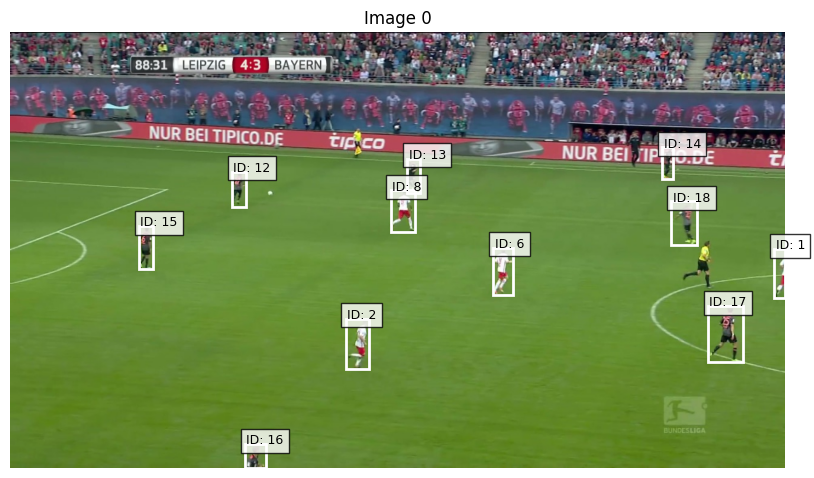

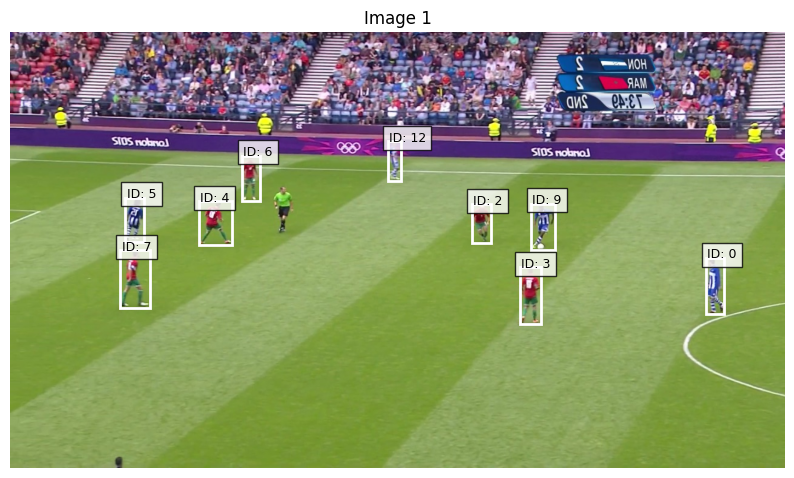

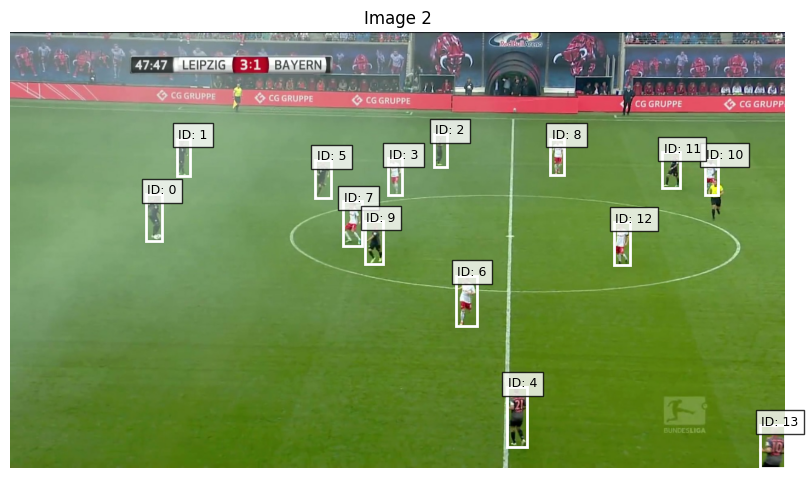

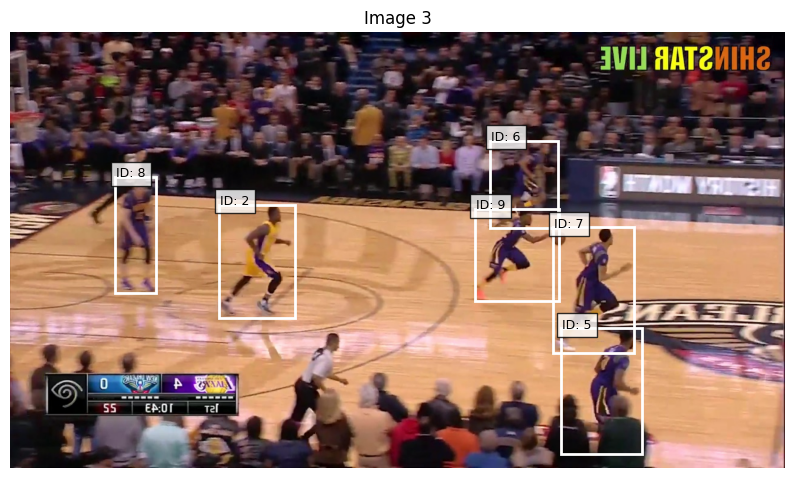

In [ ]:
def plot_images_with_boxes(images, targets, idx_offset=0):
    for i, (image, target) in enumerate(zip(images, targets)):
        img = image.permute(1, 2, 0).numpy()  
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = (img * 255).astype('uint8')
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.imshow(img)
        ax.set_title(f"Image {i + idx_offset}")

        boxes = target['boxes'].cpu().numpy()
        player_ids = target.get('player_ids', torch.tensor([])).cpu().numpy()
        
        for j, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth = 2, edgecolor='white', facecolor='none')
            ax.add_patch(rect)
            if len(player_ids) > j:
                player_id = player_ids[j]
                ax.text(x1 + 2 , y1 , f"ID: {player_id}", color='black', fontsize = 9, bbox=dict(facecolor='white', alpha=0.8))
        plt.axis('off')
        plt.show()

for idx, (images, targets) in enumerate(train_loader):
    print(f"Batch {idx + 1}:")
    plot_images_with_boxes(images, targets, idx_offset=idx * len(images))
    if idx > -1 :
        break